In [ ]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [ ]:
import torch
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

using cuda: Tesla T4


device(type='cuda')

In [ ]:

# h5py를 임포트 하여 데이터 엑세스
import h5py

import numpy
import matplotlib.pyplot as plt
#(218, 178, 3)

In [ ]:
import pandas as pd

from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import numpy as np

class CelebaDataset(Dataset):
    
    file_object=h5py.File('mount/My Drive/Colab Notebooks/firstGAN/celeba_dataset/celeba_aligned_small.h5py', 'r')
    dataset = file_object['img_align_celeba']
    # read csv
    def __init__(self):
        super().__init__()
        
    def __len__(self):
        return len(CelebaDataset.dataset)
    def __getitem__(self, index):
        array = np.array(CelebaDataset.dataset[f'{index}.jpg'])/255.0
        #return torch.tensor(array,dtype=torch.float32)
        return torch.cuda.FloatTensor(array)
        
    def plot_image(self,index):
        image = numpy.array(CelebaDataset.dataset[f'{index}.jpg'])
        #array = np.array(CelebaDataset.dataset[f'{index}.jpg'])/255.0
        plt.figure(figsize=(3,3))
        plt.imshow(image)

In [ ]:
celeba_dataset=CelebaDataset()

In [ ]:
from torch.optim import SGD,Adam
from torch.nn import MSELoss,BCELoss

class D(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(3*178*218,200),
            torch.nn.LeakyReLU(0.02),
            torch.nn.LayerNorm(200),
            torch.nn.Linear(200,1),
            torch.nn.Sigmoid(),
        )
        self.optimizer = Adam(self.parameters(),lr=0.0001)
        self.loss_fn = BCELoss()
        self.loss_hist = []
    
    def forward(self,x):
        return self.model(x)

    def train(self,x,label):
        self.optimizer.zero_grad()
        y_pred = self.model(x)
        loss = self.loss_fn(y_pred,label)
        loss.backward()
        self.optimizer.step()

        self.loss_hist.append(loss.item())
    
    def visualize(self):
        plt.figure(figsize=(12,4))
        plt.scatter(np.arange(1,len(self.loss_hist)+1),self.loss_hist,s=0.5)
        plt.title('discriminator loss')
        plt.show()    
        


In [ ]:
def gen_random(size):
    return torch.randn(size)

In [ ]:
d = D()
dataloader = DataLoader(celeba_dataset,1)
for i,img_tensor in enumerate(dataloader):
    print(i)
    if (i>100):
        break
    random=gen_random(3*178*218)
    d.train(img_tensor.reshape(-1),torch.tensor([1.0],dtype=torch.float32))
    d.train(random,torch.tensor([0.0],dtype=torch.float32))


KeyboardInterrupt: ignored

In [ ]:
d.visualize()

In [ ]:
print(d(img_tensor.reshape(-1)))
print(d(gen_random(3*178*218)))

tensor([0.9974], grad_fn=<SigmoidBackward0>)
tensor([0.0226], grad_fn=<SigmoidBackward0>)


In [ ]:
class G(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(100,200),
            torch.nn.LeakyReLU(0.02),
            torch.nn.LayerNorm(200),
            torch.nn.Linear(200,3*178*218),
            torch.nn.Sigmoid(),
        )

        self.optimizer = Adam(self.parameters(),lr=0.0001)
        
        self.loss_hist = []

    def forward(self,x):
        return self.model(x)
    
    def train(self,D,x,label):
        self.optimizer.zero_grad()
        fake_pred = self.forward(x)
        y_pred = D(fake_pred)
        loss = D.loss_fn(y_pred,label)
        loss.backward()
        self.optimizer.step()
        
        self.loss_hist.append(loss.item())
    
    def visualize(self):
        plt.figure(figsize=(4,4))
        plt.scatter(np.arange(1,len(self.loss_hist)+1),self.loss_hist,s=0.5)
        plt.title('generator loss')
        plt.show()
    
    def visualize_8img(self,x):
        fake_pred = self.forward(x).detach().numpy() # size(16,28*28)
        fake_pred = fake_pred.reshape((-1,28,28)).transpose((1,0,2)).reshape((28,-1))

        plt.figure(figsize=(16,2))
        plt.title('generator prediction')
        plt.imshow(fake_pred, cmap='Blues')
        

In [ ]:
%%time

dataloader = DataLoader(celeba_dataset,1)
d = D()
d.to(device)
g= G()
g.to(device)



for i,data in enumerate(dataloader): #enumerate 가능한가? 몇 epoch인지 출력하고 싶은데

    d.train(data.reshape(3*178*218),torch.cuda.FloatTensor([1.0]))
    d.train(g(gen_random(100)).detach(),torch.cuda.FloatTensor([0.0]))
    g.train(d,gen_random(100),torch.cuda.FloatTensor([1.0]))

    # d.train(data.reshape(3*178*218),torch.tensor([1.0],dtype=torch.float32))
    # d.train(g(gen_random(100)).detach(),torch.tensor([0.0],dtype=torch.float32))
    # g.train(d,gen_random(100),torch.tensor([1.0],dtype=torch.float32))

    if i%(100)==0:
        print(f"i {i}")   
        if (d.loss_hist):
            print(f'g loss {g.loss_hist[-1]}')
            print(f'd loss {d.loss_hist[-1]}')

i 0
g loss 0.006758469622582197
d loss 6.754852771759033
i 100
g loss 1.7310075759887695
d loss 0.16033044457435608
i 200
g loss 0.4789433479309082
d loss 0.1544361710548401
i 300
g loss 2.146817207336426
d loss 0.05534571409225464
i 400
g loss 0.2166350781917572
d loss 0.5154045820236206
i 500
g loss 1.5316917896270752
d loss 0.1251819133758545
i 600
g loss 1.3163312673568726
d loss 0.5628604888916016
i 700
g loss 1.84026038646698
d loss 0.2032359093427658
i 800
g loss 1.3098909854888916
d loss 0.24368420243263245
i 900
g loss 0.8123602271080017
d loss 0.6495239734649658
i 1000
g loss 1.2240208387374878
d loss 0.388130247592926
i 1100
g loss 1.2845193147659302
d loss 1.1730141639709473
i 1200
g loss 0.9674896001815796
d loss 0.46269434690475464
i 1300
g loss 1.8709853887557983
d loss 0.13162001967430115
i 1400
g loss 1.2120568752288818
d loss 0.330506831407547
i 1500
g loss 0.7982818484306335
d loss 0.210514634847641
i 1600
g loss 1.3973243236541748
d loss 0.2333158254623413
i 1700
g 

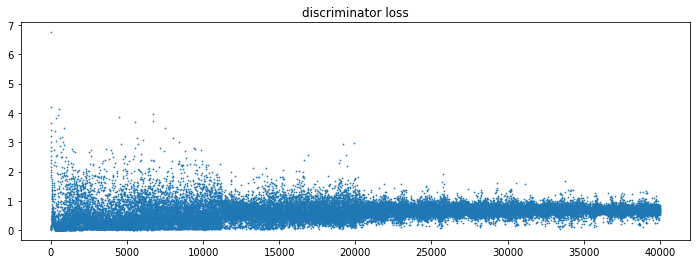

In [ ]:
d.visualize()

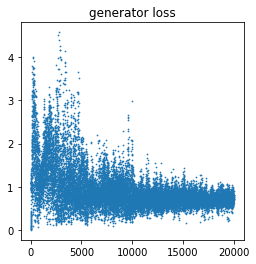

In [ ]:
g.visualize()

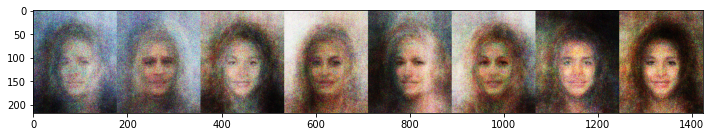

In [ ]:
fake_pred = g.forward(gen_random((8,100))).detach().cpu().numpy()
fake_pred = fake_pred.reshape(8,218,178,3).transpose(1,0,2,3).reshape(218,-1,3)
plt.figure(figsize=(12,4))
plt.imshow(fake_pred)


In [ ]:
torch.cuda.memory_allocated(device) / (1024*1024*1024)

0.7831087112426758

In [ ]:
torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

0.9574470520019531

In [ ]:
print(torch.cuda.memory_summary(device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |     801 MB |     980 MB |   17440 GB |   17439 GB |
|---------------------------------------------------------------------------|
| Active memory         |     801 MB |     980 MB |   17440 GB |   17439 GB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |     996 MB |     996 MB |     996 MB |       0 B  |
|---------------------------------------------------------------